In [1]:
using Distributions
using Random
using Roots
using StatsPlots
default(fmt = :png, size = (640, 400),
    titlefontsize = 10, plot_titlefont = 10)

In [2]:
function confdist(m, x̄, sx²)
    SEhat = √(sx²/m)
    x̄ + SEhat * TDist(m - 1)
end

function confdist(x)
    m, x̄, sx² = length(x), mean(x), var(x)
    confdist(m, x̄, sx²)
end

function tvalue(m, x̄, sx², μ = 0.0)
    (x̄ - μ) / √(sx²/m)
end

function tvalue(x, μ = 0.0)
    m, x̄, sx² = length(x), mean(x), var(x)
    tvalue(m, x̄, sx², μ)
end

function pvalue(m, x̄, sx², μ = 0.0)
    t = tvalue(m, x̄, sx², μ)
    ν = m - 1
    2ccdf(TDist(ν), abs(t))
end

function pvalue(x, μ = 0.0)
    m, x̄, sx² = length(x), mean(x), var(x)
    pvalue(m, x̄, sx², μ)
end

function confint(m, x̄, sx²; α = 0.05)
    ν = m - 1
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m)
    [x̄ - c*SEhat, x̄ + c*SEhat]
end

function confint(x; α = 0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    confint(m, x̄, sx²; α)
end

confint (generic function with 2 methods)

In [3]:
function dist_pred(m, x̄, sx²)
    SEhat = √(sx²*(1+1/m))
    x̄ + SEhat * TDist(m - 1)
end

function dist_pred(x)
    m, x̄, sx² = length(x), mean(x), var(x)
    dist_pred(m, x̄, sx²)
end

function tvalue_pred(m, x̄, sx², xnew)
    (x̄ - xnew) / √(sx²*(1+1/m))
end

function tvalue_pred(x, xnew)
    m, x̄, sx² = length(x), mean(x), var(x)
    tvalue_pred(m, x̄, sx², xnew)
end

function pvalue_pred(m, x̄, sx², xnew)
    t = tvalue_pred(m, x̄, sx², xnew)
    ν = m - 1
    2ccdf(TDist(ν), abs(t))
end

function pvalue_pred(x, xnew)
    m, x̄, sx² = length(x), mean(x), var(x)
    pvalue_pred(m, x̄, sx², xnew)
end

function predint(m, x̄, sx²; α = 0.05)
    ν = m - 1
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²*(1+1/m))
    [x̄ - c*SEhat, x̄ + c*SEhat]
end

function predint(x; α = 0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    confint_pred(m, x̄, sx²; α)
end

predint (generic function with 2 methods)

In [4]:
function logmaxlik(x)
    mle = fit_mle(Normal, x)
    loglikelihood(mle, x)
end

function maxlik(x)
    exp(logmaxlik(x))
end

function conditional_mle(x, μ)
    s = std(x; mean = μ, corrected = false)
    Normal(μ, s)
end

function conditional_logmaxlik(x, μ)
    cmle = conditional_mle(x, μ)
    loglikelihood(cmle, x)
end

function conditional_maxlik(x, μ)
    exp(conditional_logmaxlik(x, μ))
end

function logmaxlikrat(x, μ)
    conditional_logmaxlik(x, μ) - logmaxlik(x)
end

function maxlikrat(x, μ)
    exp(logmaxlikrat(x, μ))
end

function neg2loglikrat(x, μ)
    -2logmaxlikrat(x, μ)
end

function pvalue_loglikrat(x, μ)
    ccdf(Chisq(1), neg2loglikrat(x, μ))
end

function confint_loglikrat(x; α = 0.05)
    c = quantile(Chisq(1), 1 - α)
    ci = confint(x; α = α/10)
    find_zeros(μ -> neg2loglikrat(x, μ) - c, ci...)
end

confint_loglikrat (generic function with 1 method)

In [5]:
logmaxlikrat2pvalue(lmlr) = ccdf(Chisq(1), -2lmlr)
maxlikrat2pvalue(mlr) = ccdf(Chisq(1), -2log(mlr))
pvalue2logmaxlikrat(pval) = -quantile(Chisq(1), 1 - pval)/2
pvalue2maxlikrat(pval) = exp(pvalue2logmaxlikrat(pval))

pvalue2maxlikrat (generic function with 1 method)

In [6]:
function baysian_update(μ₀, λ₀, γ, θ, x)
    m, x̄, s² = length(x), mean(x), var(x)
    μ₀_new = (λ₀*μ₀ + m*x̄)/(λ₀ + m)
    λ₀_new = λ₀ + m
    γ_new = γ + m/2
    θ_new = θ/(1 + θ/2*(m*λ₀/(λ₀ + m)*(x̄ - μ₀)^2 + (m - 1)*s²))
    (μ₀ = μ₀_new, λ₀ = λ₀_new, γ = γ_new, θ = θ_new)
end

pdf_μλ(μ₀, λ₀, γ, θ, μ, λ) = pdf(Normal(μ₀, 1/√(λ*λ₀)), μ) * pdf(Gamma(γ, θ), λ)

dist_μ(μ₀, λ₀, γ, θ) = μ₀ + TDist(2γ)/√(λ₀*γ*θ)
dist_λ(μ₀, λ₀, γ, θ) = Gamma(γ, θ)

dist_x(μ₀, λ₀, γ, θ) = μ₀ + TDist(2γ)*√((1 + 1/λ₀)/(γ*θ))

function rand_μλ(μ₀, λ₀, γ, θ)
    λ = rand(Gamma(γ, θ))
    μ = rand(Normal(μ₀, 1/√(λ*λ₀)))
    (μ, λ)
end

rand_μλ(μ₀, λ₀, γ, θ, L) = [rand_μλ(μ₀, λ₀, γ, θ) for _ in 1:L]

function pvalue_bayes(x, μ;
        μ_0 = 0, sμ² = 100^2, γ = 1.5, θ = 2,
        pri = (μ₀ = 0, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ)
    )
    post = baysian_update(pri..., x)
    post_μ = dist_μ(post...)
    2ccdf(post_μ, mean(post_μ) + abs(μ - mean(post_μ)))
end

function credint(x; α = 0.05,
        μ_0 = 0, sμ² = 100^2, γ = 1.5, θ = 2,
        pri = (μ₀ = 0, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ)
    )
    post = baysian_update(pri..., x)
    post_μ = dist_μ(post...)
    quantile.(post_μ, [α/2, 1-α/2])
end

credint (generic function with 1 method)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.560365886166755
var(x) = 9.102142426957071


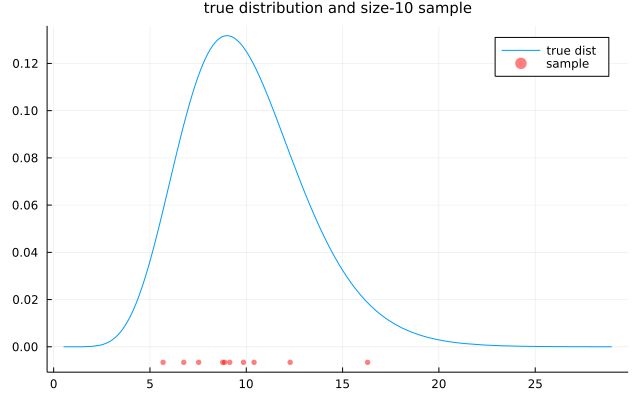

In [7]:
Random.seed!(4649373)

dist_true = Gamma(10, 1)
m = 10
x = rand(dist_true, m)

@show mean(dist_true) var(dist_true)
@show mean(x) var(x)
μ, σ = mean(dist_true), std(dist_true)
a, b = max(minimum(dist_true), μ-3σ), min(maximum(dist_true), μ+6σ)
plot(dist_true, a, b; label="true dist")
h = pdf(dist_true, mode(dist_true))
scatter!(x, fill(-0.05h, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
title!("true distribution and size-$m sample")

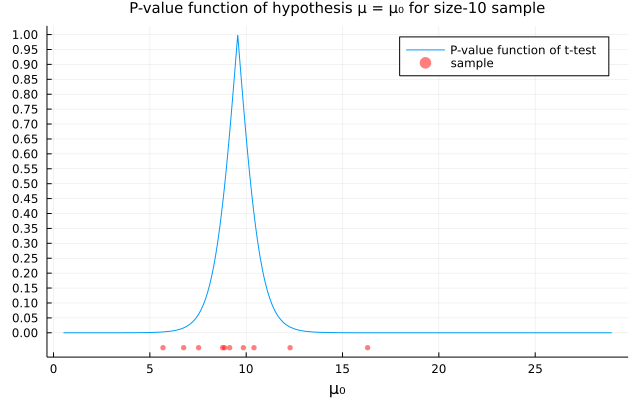

In [8]:
plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ for size-$m sample")

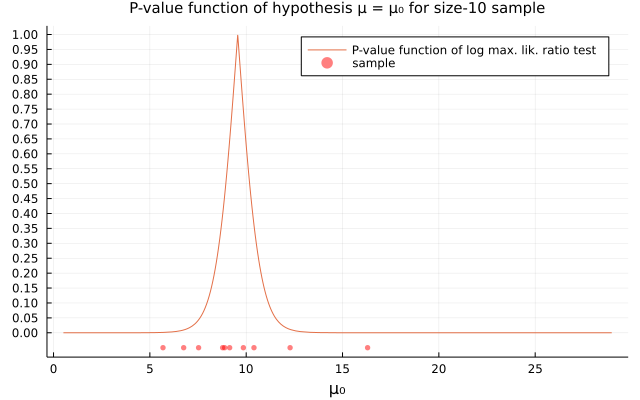

In [9]:
plot(μ₀ -> pvalue_loglikrat(x, μ₀), a, b;
    label="P-value function of log max. lik. ratio test", c=2)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ for size-$m sample")

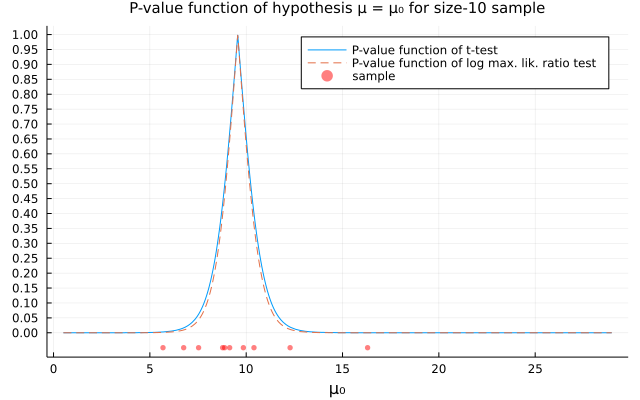

In [10]:
plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
plot!(μ₀ -> pvalue_loglikrat(x, μ₀), a, b; label="P-value function of log max. lik. ratio test", c=2, ls=:dash)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ for size-$m sample")

ci = confint(x; α) = [7.402151477794028, 11.718580294539482]


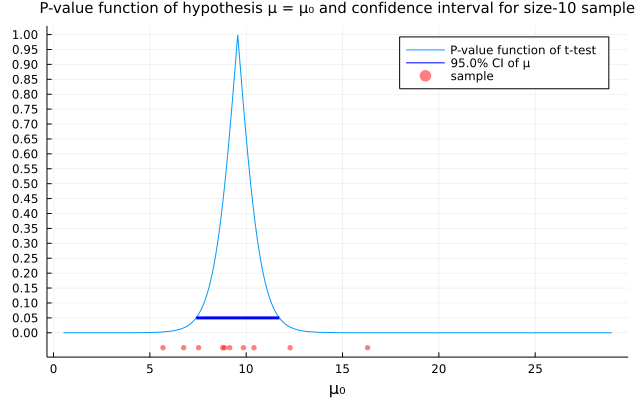

In [11]:
α = 0.05
@show ci = confint(x; α)

plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:blue)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interval for size-$m sample")

ci = confint_loglikrat(x; α) = [7.601598804244693, 11.519132968088815]


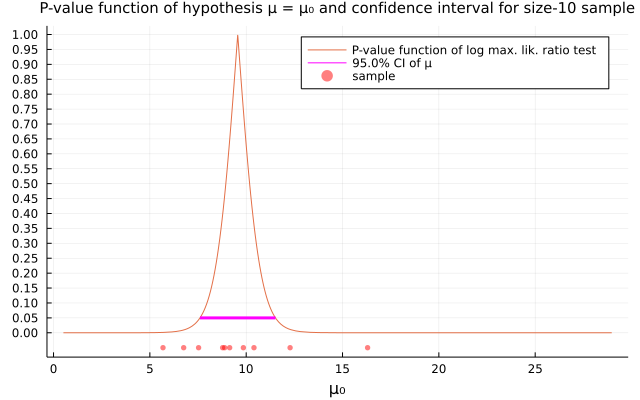

In [12]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> pvalue_loglikrat(x, μ₀), a, b;
    label="P-value function of log max. lik. ratio test", c=2)
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interval for size-$m sample")

ci = confint_loglikrat(x; α) = [7.601598804244693, 11.519132968088815]


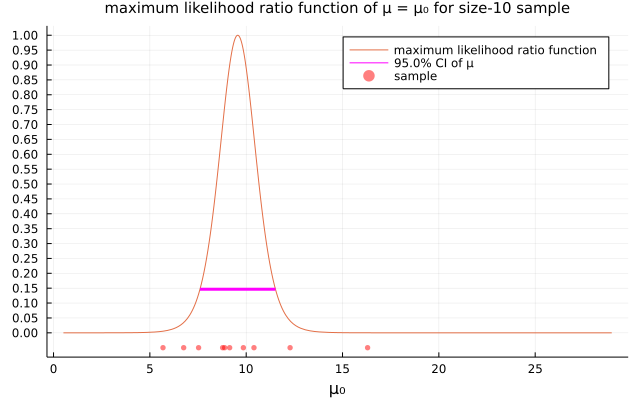

In [13]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> maxlikrat(x, μ₀), a, b; label="maximum likelihood ratio function", c=2)
c = quantile(Chisq(1), 1-α)
plot!(ci, fill(exp(-c/2), 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("maximum likelihood ratio function of μ = μ₀ for size-$m sample")

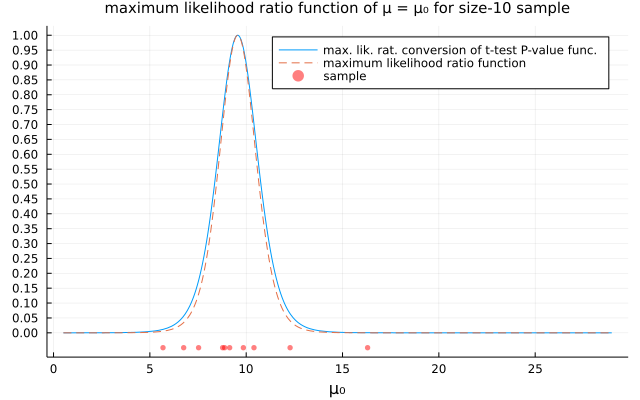

In [14]:
plot(μ₀ -> pvalue2maxlikrat(pvalue(x, μ₀)), a, b;
    label="max. lik. rat. conversion of t-test P-value func.")
plot!(μ₀ -> maxlikrat(x, μ₀), a, b;
    label="maximum likelihood ratio function", c=2, ls=:dash)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("maximum likelihood ratio function of μ = μ₀ for size-$m sample")

pri = (μ₀ = 0, λ₀ = 1 / (γ * θ * (1 - 1 / γ) * sμ²), γ, θ) = (μ₀ = 0, λ₀ = 0.0001, γ = 1.5, θ = 2)


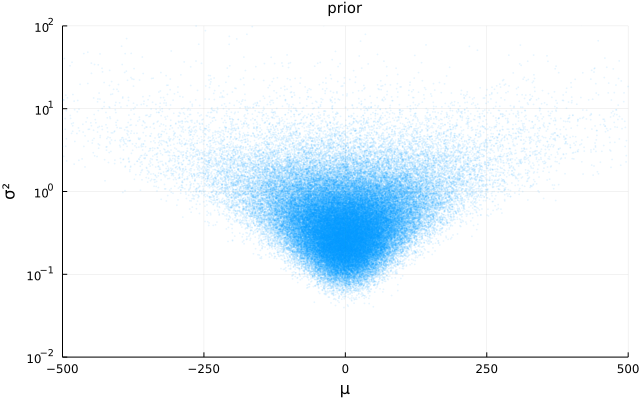

In [15]:
γ, θ = 1.5, 2
sμ² = 100^2
@show pri = (μ₀ = 0, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ)
μλ = rand_μλ(pri..., 10^5)
μσ² = [(μ, 1/λ) for (μ, λ) in μλ]
scatter(μσ²; label="", ms=1, msc=:auto, alpha=0.1)
plot!(xguide="μ", yguide="σ²")
plot!(xlim=(-500, 500), ylim=(0.01, 100), yscale=:log10)
title!("prior")

post = baysian_update(pri..., x) = (μ₀ = 9.560270283463922, λ₀ = 10.0001, γ = 6.5, θ = 0.024117183907863705)


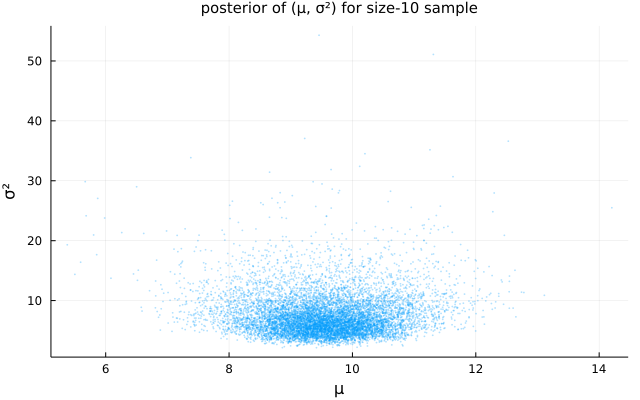

In [16]:
@show post = baysian_update(pri..., x)
μλ = rand_μλ(post..., 10^4)
μσ² = [(μ, 1/λ) for (μ, λ) in μλ]
scatter(μσ²; label="", ms=1, msc=:auto, alpha=0.3)
plot!(xguide="μ", yguide="σ²")
title!("posterior of (μ, σ²) for size-$m sample")

post_μ = dist_μ(post...) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 9.560270283463922
σ: 0.7986892749753106
ρ: TDist{Float64}(ν=13.0)
)

ci = credint(x; α, pri) = [7.834807007554268, 11.285733559373575]


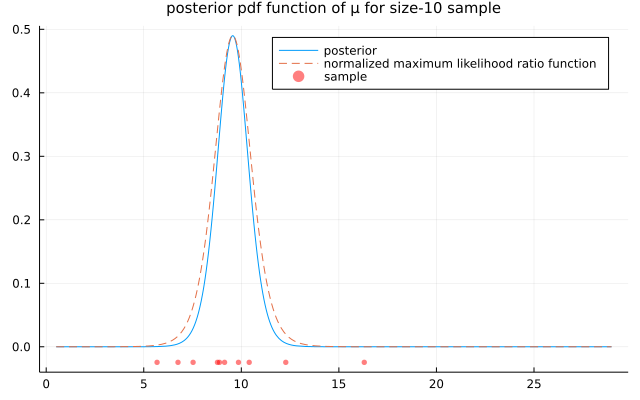

In [17]:
α = 0.05

@show post_μ = dist_μ(post...)
@show ci = credint(x; α, pri)
plot(post_μ, a, b; label="posterior")
c = pdf(post_μ, mode(post_μ))
plot!(μ₀ -> c*maxlikrat(x, μ₀), a, b;
    label="normalized maximum likelihood ratio function", c=2, ls=:dash)
scatter!(x, fill(-0.05c, 2); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
title!("posterior pdf function of μ for size-$m sample")

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.169403594454309
var(x) = 6.925622020000762


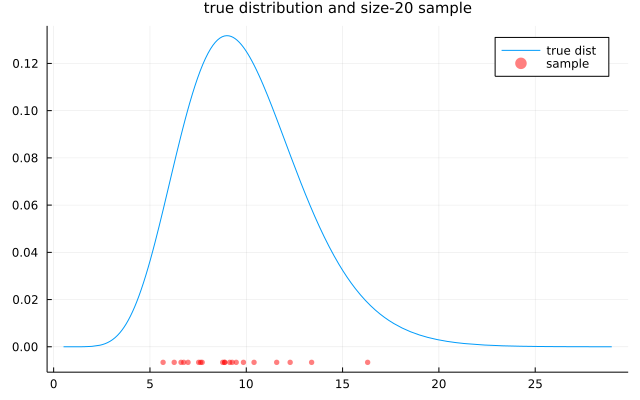

In [18]:
Random.seed!(4649373)

dist_true = Gamma(10, 1)
m = 20
x = rand(dist_true, m)

@show mean(dist_true) var(dist_true)
@show mean(x) var(x)
μ, σ = mean(dist_true), std(dist_true)
a, b = max(minimum(dist_true), μ-3σ), min(maximum(dist_true), μ+6σ)
plot(dist_true, a, b; label="true dist")
h = pdf(dist_true, mode(dist_true))
scatter!(x, fill(-0.05h, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
title!("true distribution and size-$m sample")

ci = confint(x; α) = [7.937749898537216, 10.401057290371401]


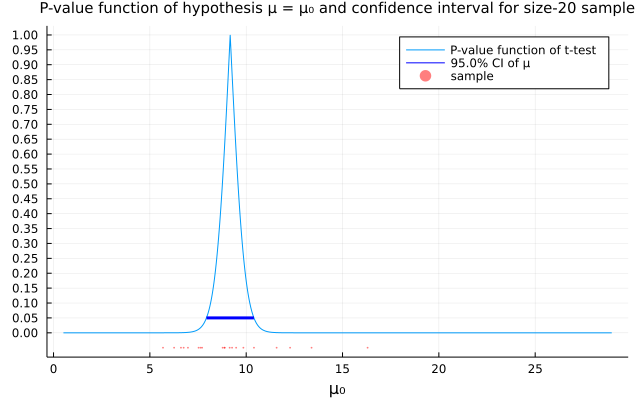

In [19]:
α = 0.05
@show ci = confint(x; α)

plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:blue)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interval for size-$m sample")

ci = confint_loglikrat(x; α) = [7.989050257411121, 10.349756931497492]


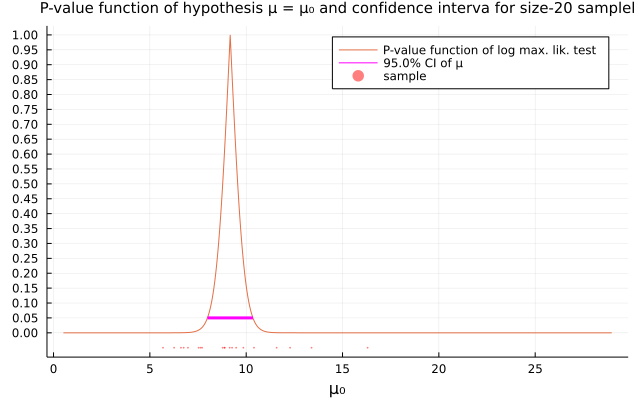

In [20]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> pvalue_loglikrat(x, μ₀), a, b;
    label="P-value function of log max. lik. test", c=2)
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interva for size-$m samplel")

ci = confint_loglikrat(x; α) = [7.989050257411121, 10.349756931497492]


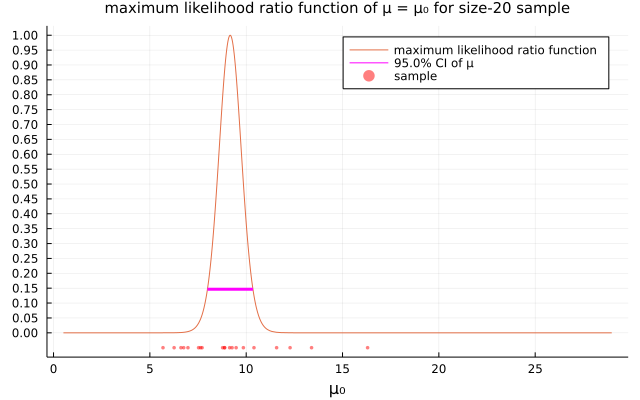

In [21]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> maxlikrat(x, μ₀), a, b; label="maximum likelihood ratio function", c=2)
c = quantile(Chisq(1), 1-α)
plot!(ci, fill(exp(-c/2), 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=2, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("maximum likelihood ratio function of μ = μ₀ for size-$m sample")

post = baysian_update(pri..., x) = (μ₀ = 9.16935774766557, λ₀ = 20.0001, γ = 11.5, θ = 0.015083499295636342)


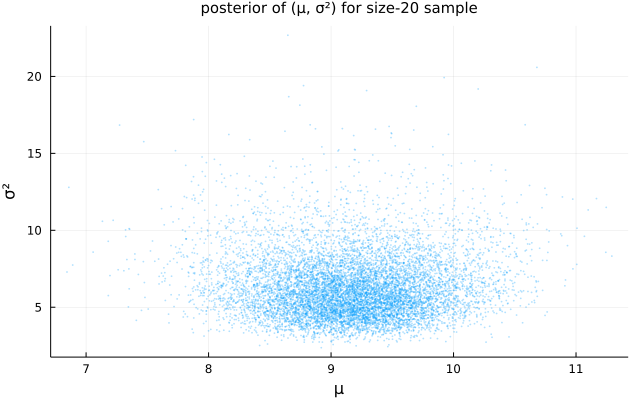

In [22]:
@show post = baysian_update(pri..., x)
μλ = rand_μλ(post..., 10^4)
μσ² = [(μ, 1/λ) for (μ, λ) in μλ]
scatter(μσ²; label="", ms=1, msc=:auto, alpha=0.3)
plot!(xguide="μ", yguide="σ²")
title!("posterior of (μ, σ²) for size-$m sample")

post_μ = dist_μ(post...) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 9.16935774766557
σ: 0.5368883034215244
ρ: TDist{Float64}(ν=23.0)
)

ci = credint(x; α, pri) = [8.058719672847662, 10.279995822483478]


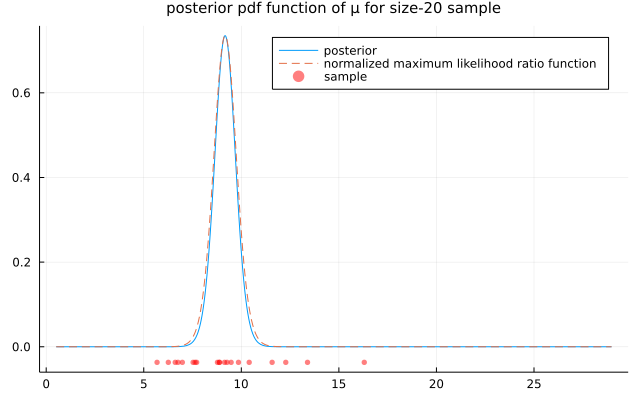

In [23]:
α = 0.05

@show post_μ = dist_μ(post...)
@show ci = credint(x; α, pri)
plot(post_μ, a, b; label="posterior")
c = pdf(post_μ, mode(post_μ))
plot!(μ₀ -> c*maxlikrat(x, μ₀), a, b;
    label="normalized maximum likelihood ratio function", c=2, ls=:dash)
scatter!(x, fill(-0.05c, 2); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
title!("posterior pdf function of μ for size-$m sample")

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.579496676858493
var(x) = 9.648827100253905


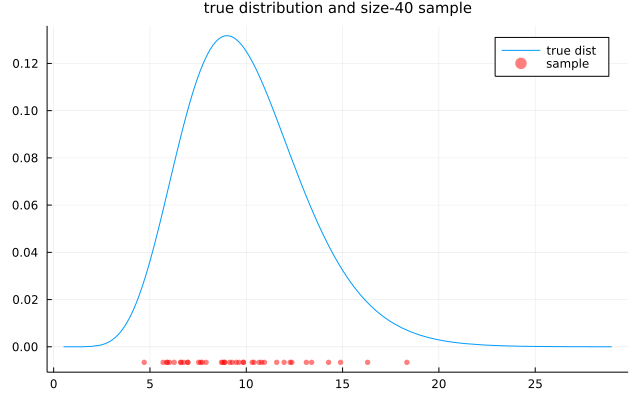

In [24]:
Random.seed!(4649373)

dist_true = Gamma(10, 1)
m = 40
x = rand(dist_true, m)

@show mean(dist_true) var(dist_true)
@show mean(x) var(x)
μ, σ = mean(dist_true), std(dist_true)
a, b = max(minimum(dist_true), μ-3σ), min(maximum(dist_true), μ+6σ)
plot(dist_true, a, b; label="true dist")
h = pdf(dist_true, mode(dist_true))
scatter!(x, fill(-0.05h, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
title!("true distribution and size-$m sample")

ci = confint(x; α) = [8.586067773701478, 10.572925580015509]


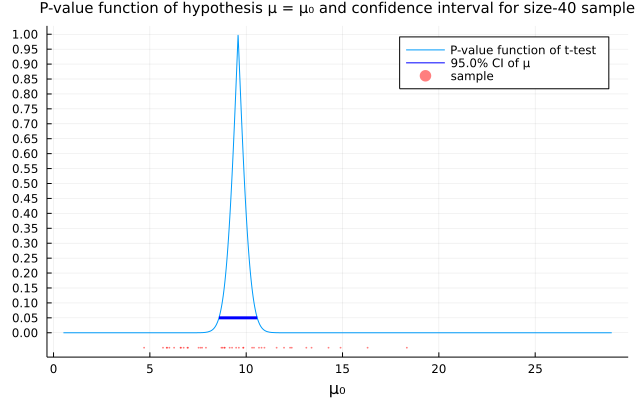

In [25]:
α = 0.05
@show ci = confint(x; α)

plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:blue)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interval for size-$m sample")

ci = confint_loglikrat(x; α) = [8.60570034537923, 10.553293008337757]


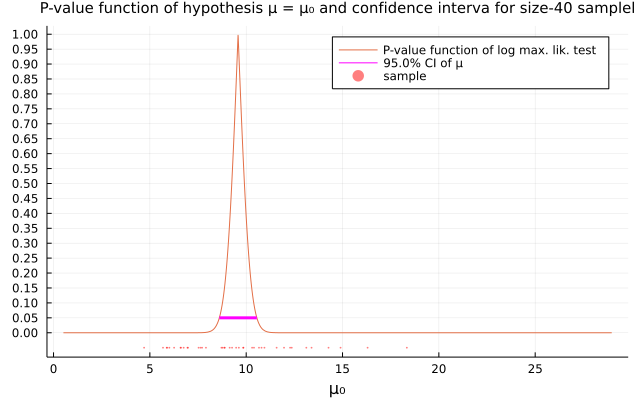

In [26]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> pvalue_loglikrat(x, μ₀), a, b;
    label="P-value function of log max. lik. test", c=2)
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interva for size-$m samplel")

ci = confint_loglikrat(x; α) = [8.60570034537923, 10.553293008337757]


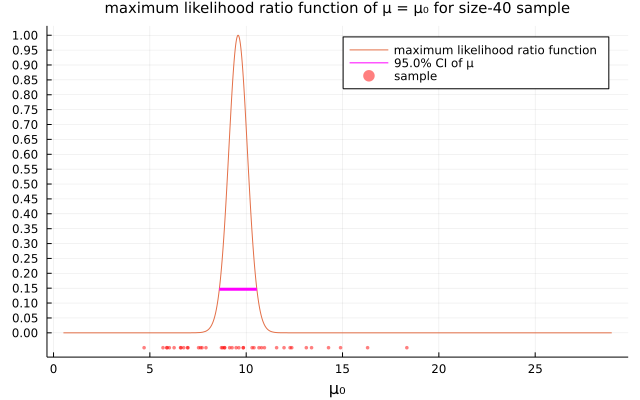

In [27]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> maxlikrat(x, μ₀), a, b; label="maximum likelihood ratio function", c=2)
c = quantile(Chisq(1), 1-α)
plot!(ci, fill(exp(-c/2), 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=2, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("maximum likelihood ratio function of μ = μ₀ for size-$m sample")

post = baysian_update(pri..., x) = (μ₀ = 9.579472728176674, λ₀ = 40.0001, γ = 21.5, θ = 0.005300632901182089)


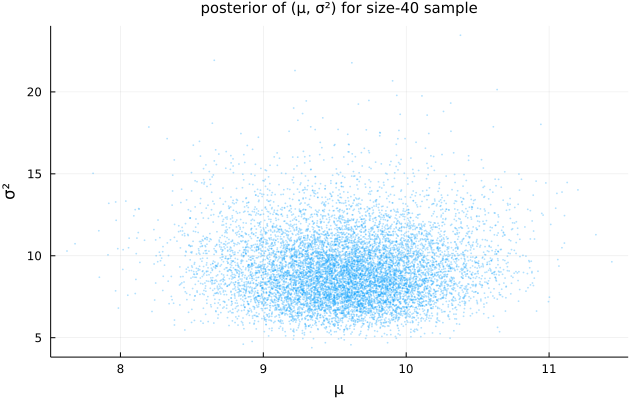

In [28]:
@show post = baysian_update(pri..., x)
μλ = rand_μλ(post..., 10^4)
μσ² = [(μ, 1/λ) for (μ, λ) in μλ]
scatter(μσ²; label="", ms=1, msc=:auto, alpha=0.3)
plot!(xguide="μ", yguide="σ²")
title!("posterior of (μ, σ²) for size-$m sample")

post_μ = dist_μ(post...) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 9.579472728176674
σ: 0.4683670856366689
ρ: TDist{Float64}(ν=43.0)
)

ci = credint(x; α, pri) = [8.634920480198133, 10.524024976155214]


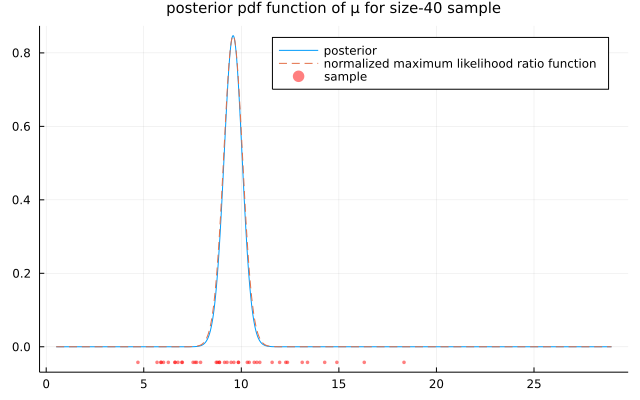

In [29]:
α = 0.05

@show post_μ = dist_μ(post...)
@show ci = credint(x; α, pri)
plot(post_μ, a, b; label="posterior")
c = pdf(post_μ, mode(post_μ))
plot!(μ₀ -> c*maxlikrat(x, μ₀), a, b;
    label="normalized maximum likelihood ratio function", c=2, ls=:dash)
scatter!(x, fill(-0.05c, 2); label="sample", ms=2, msc=:auto, alpha=0.5, c=:red)
title!("posterior pdf function of μ for size-$m sample")

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 10.238949304243299
var(x) = 14.672034716535684


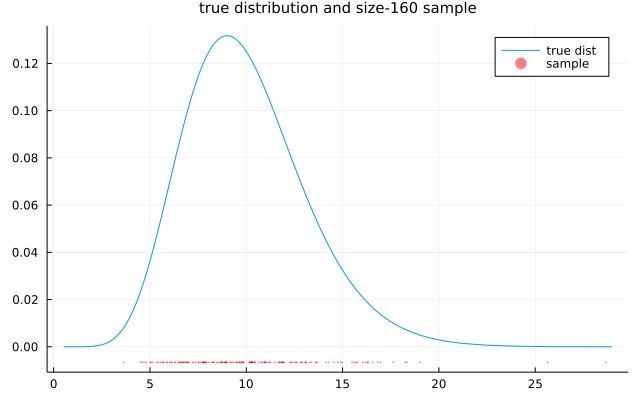

In [30]:
Random.seed!(4649373)

dist_true = Gamma(10, 1)
m = 160
x = rand(dist_true, m)

@show mean(dist_true) var(dist_true)
@show mean(x) var(x)
μ, σ = mean(dist_true), std(dist_true)
a, b = max(minimum(dist_true), μ-3σ), min(maximum(dist_true), μ+6σ)
plot(dist_true, a, b; label="true dist")
h = pdf(dist_true, mode(dist_true))
scatter!(x, fill(-0.05h, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
title!("true distribution and size-$m sample")

ci = confint(x; α) = [9.64088008830186, 10.837018520184738]


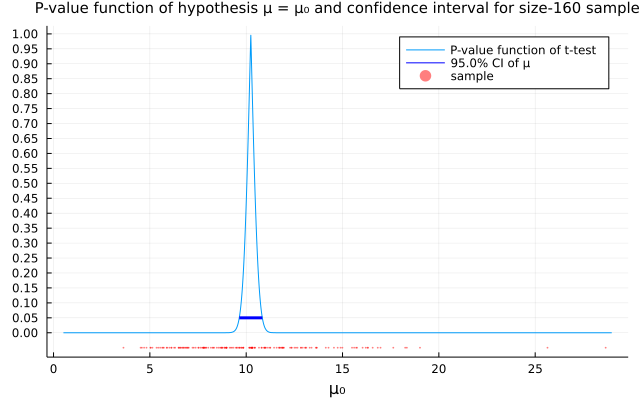

In [31]:
α = 0.05
@show ci = confint(x; α)

plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:blue)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interval for size-$m sample")

ci = confint_loglikrat(x; α) = [9.643720669380585, 10.834177939106027]


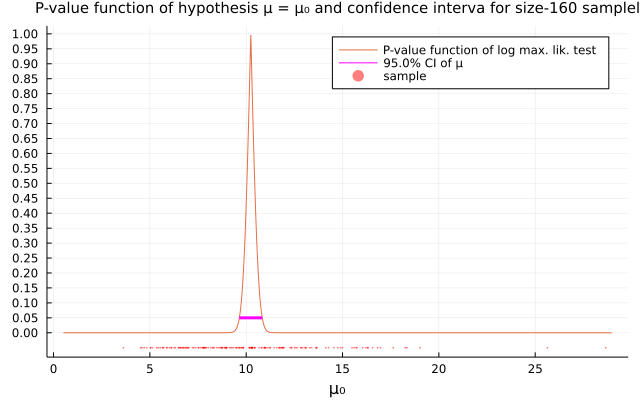

In [32]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> pvalue_loglikrat(x, μ₀), a, b;
    label="P-value function of log max. lik. test", c=2)
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interva for size-$m samplel")

ci = confint_loglikrat(x; α) = [9.643720669380585, 10.834177939106027]


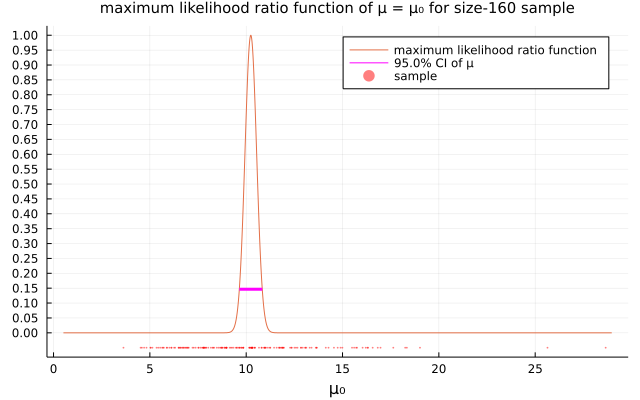

In [33]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> maxlikrat(x, μ₀), a, b; label="maximum likelihood ratio function", c=2)
c = quantile(Chisq(1), 1-α)
plot!(ci, fill(exp(-c/2), 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("maximum likelihood ratio function of μ = μ₀ for size-$m sample")

post = baysian_update(pri..., x) = (μ₀ = 10.238942904903983, λ₀ = 160.0001, γ = 81.5, θ = 0.0008569479613954355)


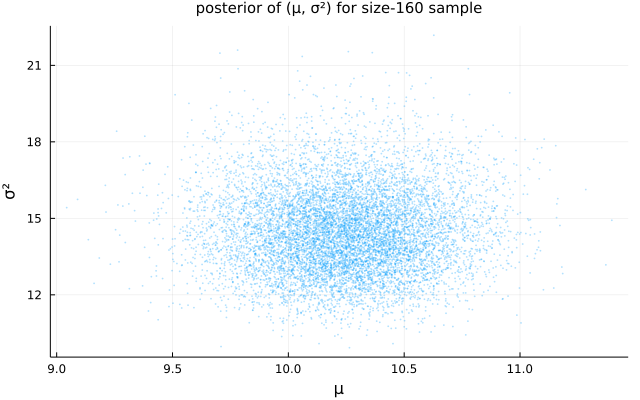

In [34]:
@show post = baysian_update(pri..., x)
μλ = rand_μλ(post..., 10^4)
μσ² = [(μ, 1/λ) for (μ, λ) in μλ]
scatter(μσ²; label="", ms=1, msc=:auto, alpha=0.3)
plot!(xguide="μ", yguide="σ²")
title!("posterior of (μ, σ²) for size-$m sample")

post_μ = dist_μ(post...) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 10.238942904903983
σ: 0.2991464432544108
ρ: TDist{Float64}(ν=163.0)
)

ci = credint(x; α, pri) = [9.648240972779307, 10.829644837028658]


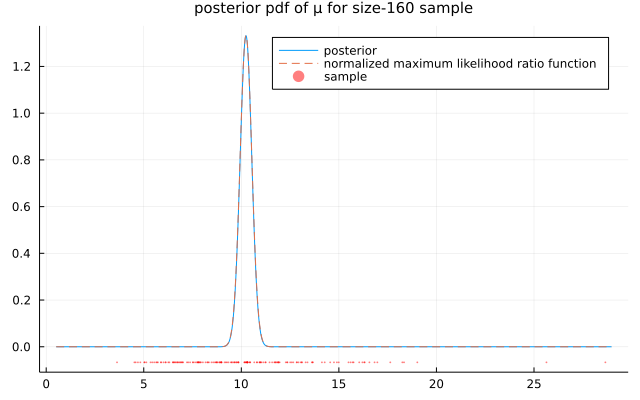

In [35]:
α = 0.05

@show post_μ = dist_μ(post...)
@show ci = credint(x; α, pri)
plot(post_μ, a, b; label="posterior")
c = pdf(post_μ, mode(post_μ))
plot!(μ₀ -> c*maxlikrat(x, μ₀), a, b;
    label="normalized maximum likelihood ratio function", c=2, ls=:dash)
scatter!(x, fill(-0.05c, 2); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
title!("posterior pdf of μ for size-$m sample")

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 10.202442914009827
var(x) = 11.005589278544607


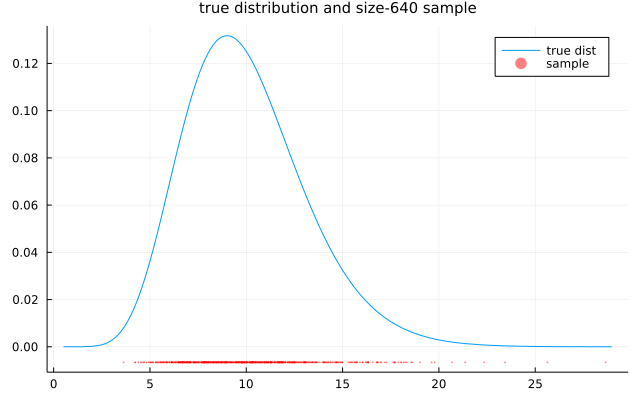

In [36]:
Random.seed!(4649373)

dist_true = Gamma(10, 1)
m = 640
x = rand(dist_true, m)

@show mean(dist_true) var(dist_true)
@show mean(x) var(x)
μ, σ = mean(dist_true), std(dist_true)
a, b = max(minimum(dist_true), μ-3σ), min(maximum(dist_true), μ+6σ)
plot(dist_true, a, b; label="true dist")
h = pdf(dist_true, mode(dist_true))
scatter!(x, fill(-0.05h, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
title!("true distribution and size-$m sample")

ci = confint(x; α) = [9.944936454156132, 10.459949373863523]


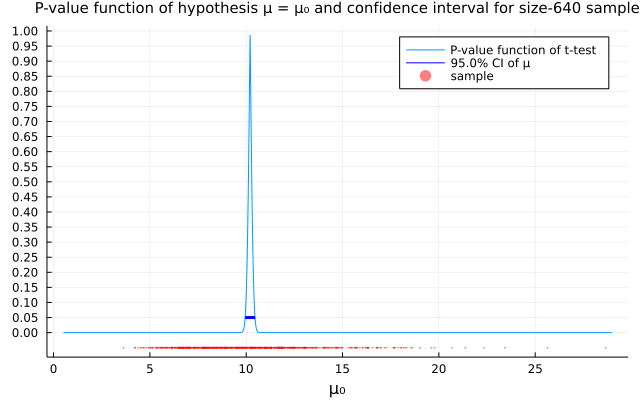

In [37]:
α = 0.05
@show ci = confint(x; α)

plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:blue)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interval for size-$m sample")

ci = confint_loglikrat(x; α) = [9.945239213979908, 10.459646614039961]


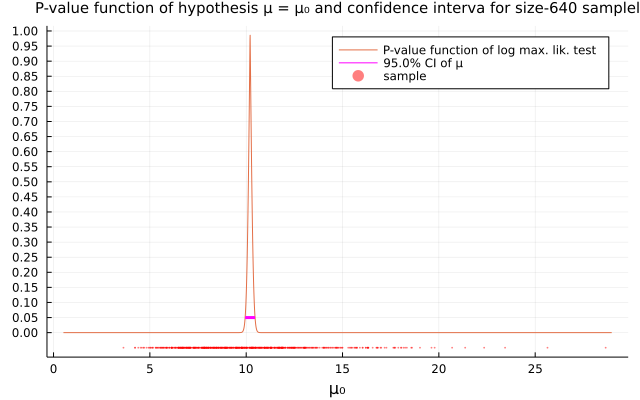

In [38]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> pvalue_loglikrat(x, μ₀), a, b;
    label="P-value function of log max. lik. test", c=2)
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interva for size-$m samplel")

ci = confint_loglikrat(x; α) = [9.945239213979908, 10.459646614039961]


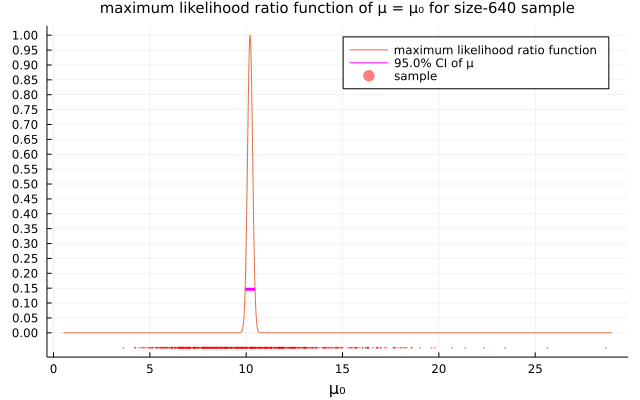

In [39]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> maxlikrat(x, μ₀), a, b; label="maximum likelihood ratio function", c=2)
c = quantile(Chisq(1), 1-α)
plot!(ci, fill(exp(-c/2), 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("maximum likelihood ratio function of μ = μ₀ for size-$m sample")

post = baysian_update(pri..., x) = (μ₀ = 10.202441319878371, λ₀ = 640.0001, γ = 321.5, θ = 0.0002843501379454338)


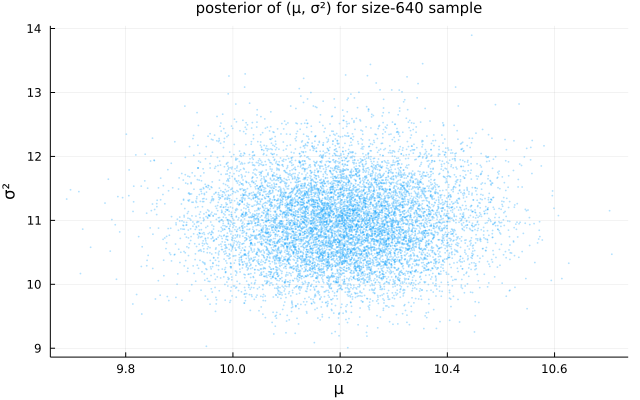

In [40]:
@show post = baysian_update(pri..., x)
μλ = rand_μλ(post..., 10^4)
μσ² = [(μ, 1/λ) for (μ, λ) in μλ]
scatter(μσ²; label="", ms=1, msc=:auto, alpha=0.3)
plot!(xguide="μ", yguide="σ²")
title!("posterior of (μ, σ²) for size-$m sample")

post_μ = dist_μ(post...) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 10.202441319878371
σ: 0.13073527019997352
ρ: TDist{Float64}(ν=643.0)
)

ci = credint(x; α, pri) = [9.945721672957875, 10.459160966798867]


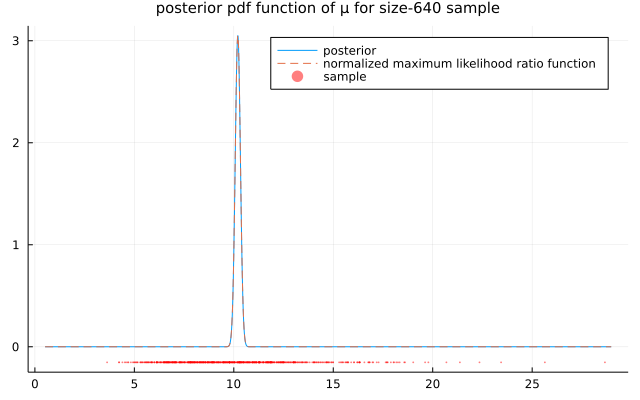

In [41]:
α = 0.05

@show post_μ = dist_μ(post...)
@show ci = credint(x; α, pri)
plot(post_μ, a, b; label="posterior")
c = pdf(post_μ, mode(post_μ))
plot!(μ₀ -> c*maxlikrat(x, μ₀), a, b;
    label="normalized maximum likelihood ratio function", c=2, ls=:dash)
scatter!(x, fill(-0.05c, 2); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
title!("posterior pdf function of μ for size-$m sample")

In [42]:
function plot_ttest(;
        dist_true = Gamma(10, 1),
        m = 10,
        x = rand(dist_true, m),
        μ_0 = 0, sμ² = 100^2, γ = 1.5, θ = 2,
        pri = (μ₀ = 0, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ),
    )

    μ, σ = mean(dist_true), std(dist_true)
    a, b = max(minimum(dist_true), μ - 5σ), min(maximum(dist_true), μ + 5σ)

    post = baysian_update(pri..., x)
    post_μ = dist_μ(post...)
    pred_xnew = dist_x(post...)
    μ_xnew = mean(pred_xnew)
    
    @show mean(dist_true) var(dist_true)
    @show mean(x) var(x)
    @show mean(dist_pred(x)) var(dist_pred(x))
    @show mean(pred_xnew) var(pred_xnew)
    
    P1 = plot(μ -> pvalue(x, μ), a, b; label="t-test")
    plot!(μ -> pvalue_bayes(x, μ), a, b; label="Bayesian", ls=:dash)
    scatter!(x, fill(-0.05, length(x)); label="sample", ms=1.5, msc=:auto, alpha=0.5, c=:red)
    title!("P-value functions")

    P2 = plot(μ -> pdf(confdist(x), μ), a, b; label="t-test")
    plot!(μ -> pdf(post_μ, μ), a, b; label="Bayesian", ls=:dash)
    h = pdf(confdist(x), mode(confdist(x)))
    scatter!(x, fill(-0.05h, length(x)); label="sample", ms=1.5, msc=:auto, alpha=0.5, c=:red)
    title!("parameter distributions")

    P3 = plot(xnew -> pvalue_pred(x, xnew), a, b; label="t-test")
    plot!(xnew -> 2ccdf(pred_xnew, μ_xnew + abs(xnew - μ_xnew)), a, b;
        label="Bayesian", ls=:dash)
    scatter!(x, fill(-0.05, length(x)); label="sample", ms=1.5, msc=:auto, alpha=0.5, c=:red)
    title!("prediction P-value functions")

    P4 = plot(xnew -> pdf(dist_pred(x), xnew), a, b; label="t-test")
    plot!(xnew -> pdf(pred_xnew, xnew), a, b; label="Bayesian", ls=:dash)
    plot!(dist_true, a, b; label="true dist", ls=:dot, c=:black)
    h = pdf(dist_pred(x), mode(dist_pred(x)))
    scatter!(x, fill(-0.05h, length(x)); label="sample", ms=1.5, msc=:auto, alpha=0.5, c=:red)
    title!("prediction distributions")

    plot(P1, P2, P3, P4; size=(800, 500), layout=(2, 2))
    plot!(; plot_title="P-value functions, etc. for size-$m sample of $(dist_true)")
end

plot_ttest (generic function with 1 method)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.560365886166755
var(x) = 9.102142426957071
mean(dist_pred(x)) = 9.560365886166755
var(dist_pred(x)) = 12.87303000383929
mean(pred_xnew) = 9.560270283463922
var(pred_xnew) = 8.29283464220812


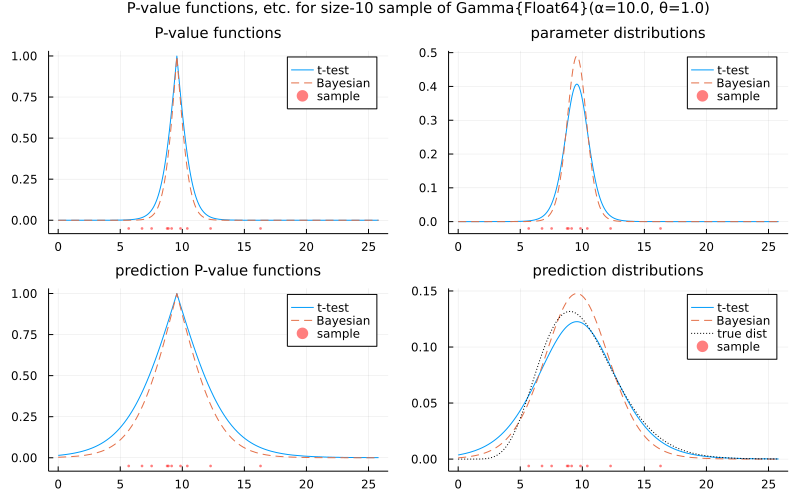

In [43]:
Random.seed!(4649373)
plot_ttest(m = 10)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.169403594454309
var(x) = 6.925622020000762
mean(dist_pred(x)) = 9.169403594454309
var(dist_pred(x)) = 8.127421135236187
mean(pred_xnew) = 9.16935774766557
var(pred_xnew) = 6.62975972820347


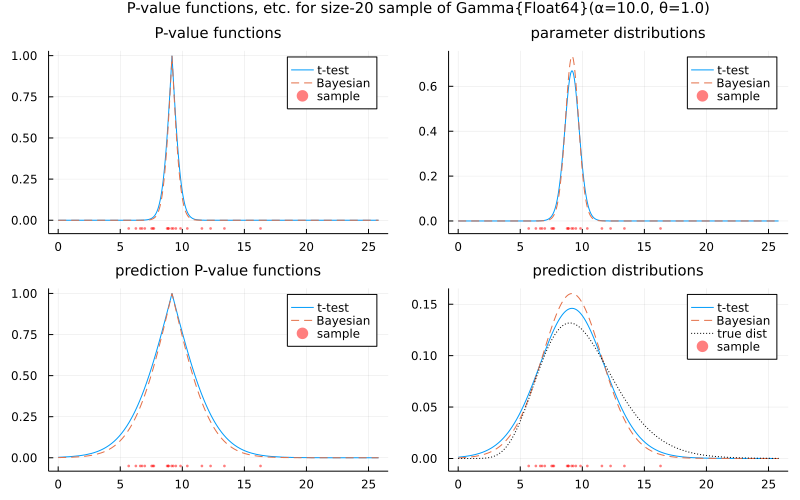

In [44]:
Random.seed!(4649373)
plot_ttest(m = 20)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.031727755767667
var(x) = 7.009850017505368
mean(dist_pred(x)) = 9.031727755767667
var(dist_pred(x)) = 7.780068105848552
mean(pred_xnew) = 9.031697650108834
var(pred_xnew) = 6.8097928574695885


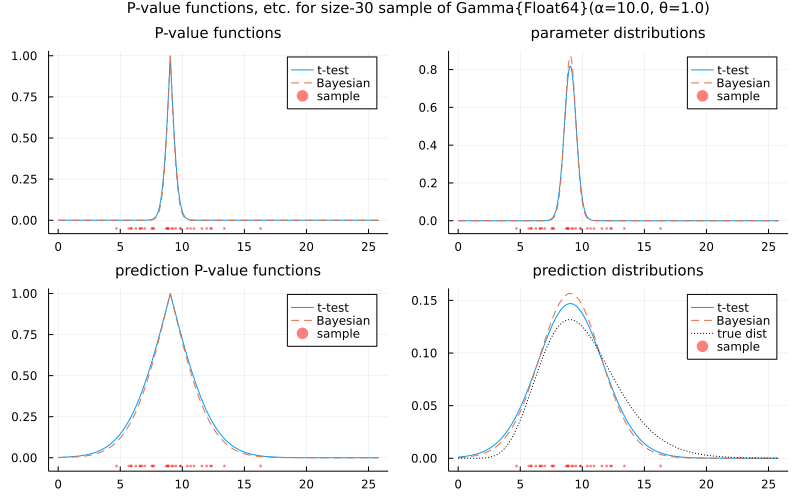

In [45]:
Random.seed!(4649373)
plot_ttest(m = 30)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.579496676858493
var(x) = 9.648827100253905
mean(dist_pred(x)) = 9.579496676858493
var(dist_pred(x)) = 10.42464495493648
mean(pred_xnew) = 9.579472728176674
var(pred_xnew) = 9.432835263893997


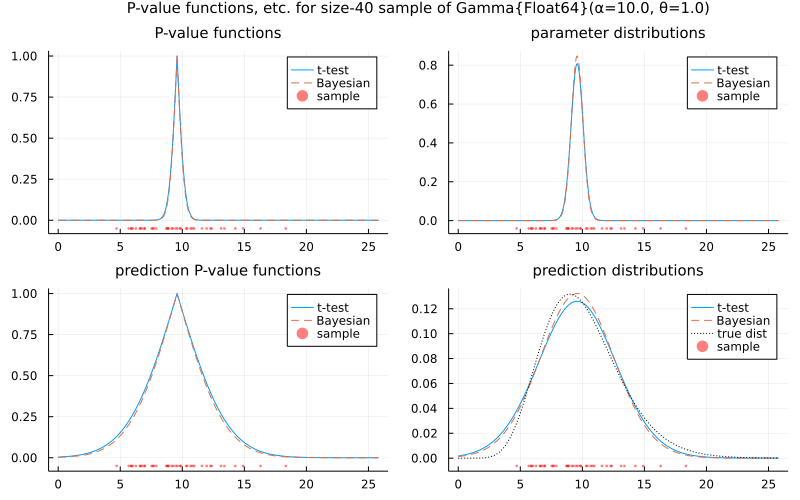

In [46]:
Random.seed!(4649373)
plot_ttest(m = 40)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.73660236221831
var(x) = 9.366625205018313
mean(dist_pred(x)) = 9.73660236221831
var(dist_pred(x)) = 9.730038098524703
mean(pred_xnew) = 9.73659019148057
var(pred_xnew) = 9.262160748655003


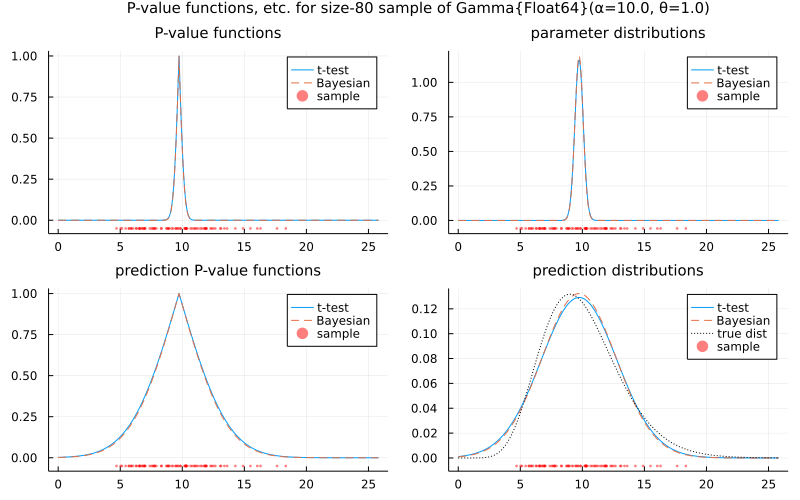

In [47]:
Random.seed!(4649373)
plot_ttest(m = 80)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 10.238949304243299
var(x) = 14.672034716535684
mean(dist_pred(x)) = 10.238949304243299
var(dist_pred(x)) = 14.951807989991918
mean(pred_xnew) = 10.238942904903983
var(pred_xnew) = 14.58664996544301


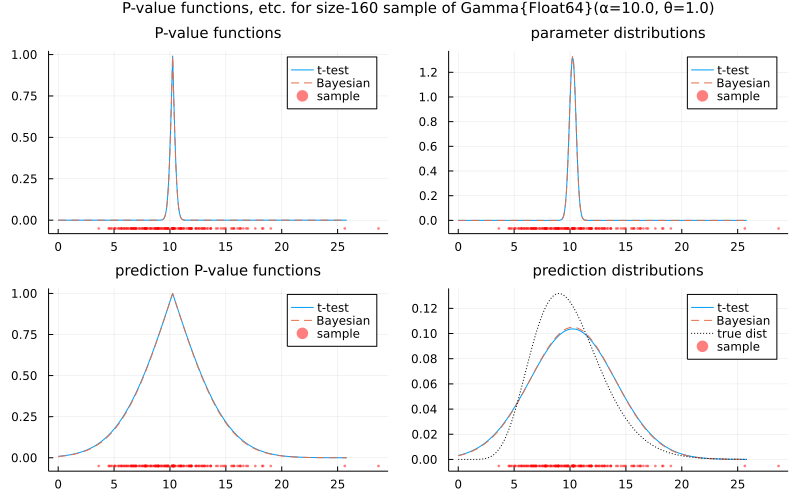

In [48]:
Random.seed!(4649373)
plot_ttest(m = 160)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 10.159962619271074
var(x) = 12.661776312987087
mean(dist_pred(x)) = 10.159962619271074
var(dist_pred(x)) = 12.781479028722051
mean(pred_xnew) = 10.159959444283748
var(pred_xnew) = 12.625365507470512


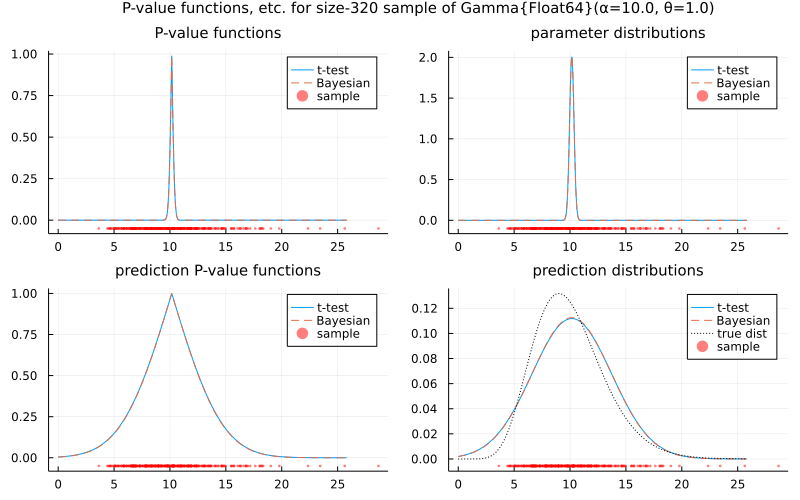

In [49]:
Random.seed!(4649373)
plot_ttest(m = 320)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 10.202442914009827
var(x) = 11.005589278544607
mean(dist_pred(x)) = 10.202442914009827
var(dist_pred(x)) = 11.057393943540502
mean(pred_xnew) = 10.202441319878371
var(pred_xnew) = 10.989971806653148


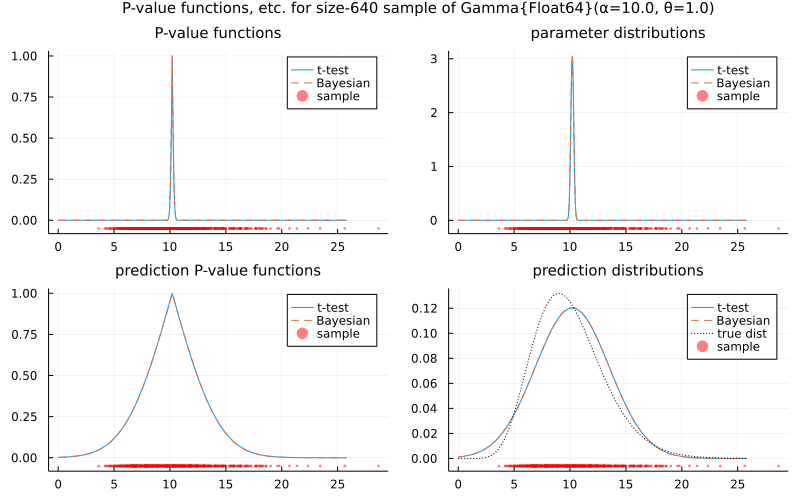

In [50]:
Random.seed!(4649373)
plot_ttest(m = 640)